# Titanic: Machine Learning from Disaster

The goal of this model is given set of features to predict if passanger survived the trangedy of RMS Titanic in 1912.

I have done no research on other participant contributions to not get biased towards their solutions and try something completely of my own.

## Data ##
**Dataset:** 891 data points, 10 features, 1 label
**Test set:** 418 data points, 10 features

**Features**:
- Class of travel
- Name
- Gender
- Age
- Number of Sibling/Spouse aboard
- Number of Parent/Child aboard
- Ticket
- Fare
- Cabin
- Embarked

Not all passangers have all features. Also some features such as Name, Ticket or Cabin do not have standardized format.

**Labels**:
- Survived: 1 if passanger survived the tragedy, 0 if not

In [246]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
import tensorflow as tf
if tf.__version__ == "2.0.0-alpha0":
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers
    from tensorflow.keras.layers import Input, Dense, Flatten
    from tensorflow.keras.models import Model
else:
    from keras import layers
    from keras import optimizers
    from keras.layers import Input, Dense, Flatten
    from keras.models import Model
import pandas as pd
import numpy as np
import matplotlib
print(tf.__version__)

2.0.0-alpha0


In [247]:
# Load dataset
dataset = pd.read_csv("dataset/train.csv")

In [248]:
dataset.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [249]:
print("#samples: "+str(dataset.shape[0]))
print("#features: "+str(dataset.shape[1]-2)) # -2 for Id and label

#samples: 891
#features: 10


All features might not be present in all examples:

In [250]:
print(dataset.count())

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64


Balance of the dataset:

In [251]:
num_of_survived = dataset[dataset.Survived == 1].Survived.count()
num_of_not_survived = dataset.shape[0]-num_of_survived
print("Passangers that survived: %d, %.2f%%" % (num_of_survived,  num_of_survived/dataset.shape[0]*100))
print("Passangers that did not survived: %d, %.2f%%" % (num_of_not_survived,  num_of_not_survived/dataset.shape[0]*100))

Passangers that survived: 342, 38.38%
Passangers that did not survived: 549, 61.62%


## Feature analysis ##

For the first, simplest model, lets focus on features that do not need a lot of preprocessing. Thus we ommit Name, Ticket and Cabin.

Name feature could give us information about wealth of the passanger, however we already receive the Class of travel which should be good indicator and we might need much bigger dataset to extract such information from the dataset.

Cabin feature could be very helpful, however Cabin information is present in only 204 samples, is unique (would need preprocessing to add information about the location of the cabin) and some passangers have more than 1.

Ticket feature might give similar information as Cabin and Class of travel, but similarly as in Cabin needs research to extract useful information and preprocessing since it does not always have standardized format.

**Class of travel**

Contains information about wealth of the passanger and likely position of the cabin on the ship.

It can take value from 1,2 or 3 from 1 being the most luxurious. Lets see the distribution in the dataset:

In [252]:
dataset.groupby(['Survived', 'Pclass'])["Pclass"].count()

Survived  Pclass
0         1          80
          2          97
          3         372
1         1         136
          2          87
          3         119
Name: Pclass, dtype: int64

From numbers above it can be seen that only 1/4 of passangers in 3rd class in the dataset survived, however more than 3/5 of passangers in 1st class survived. Showing that Class of travel is possibly good feature.

**Gender**

Gender is potentially very usefull feature considering RMS Titanic being famous for the phrase "Woman and children first". According to blog post (https://blog.minitab.com/blog/real-world-quality-improvement/analyzing-titanic-survival-rates) which analyzed available data 73% of female passangers survived and only 21% of male passangers did.

Lets see the distribution in our dataset:

In [253]:
dataset.groupby(['Survived', 'Sex'])["Sex"].count()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Sex, dtype: int64

In [254]:
print("Female survived: %.2f%%, Male survived: %.2f%%" % (233/(81+233)*100, 109/(109+468)*100))

Female survived: 74.20%, Male survived: 18.89%


**Age**

I suspect Age to be partially missledaing. Firstly, I lack knowledge about the policy that took place considering age - if they prioritized elderly or young. However even if prioritization would go towards elderly, they might be more prone to not being able to get to lifeboats in time.

Again, lets look at the distribution:

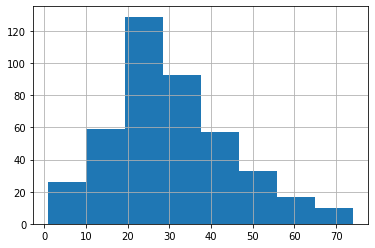

In [255]:
dataset[dataset["Survived"]==0]["Age"].hist(bins=8)

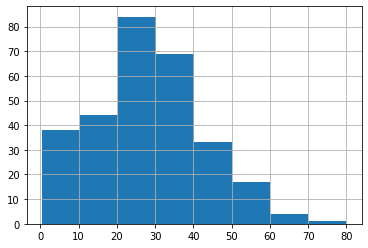

In [256]:
dataset[dataset["Survived"]==1]["Age"].hist(bins=8)

Distributions seem very similar, however one can notice significantly higher group of younger passangers survived and signifantly higher group of older passangers did not. This suggests children were priority.

**Number of Sibling/Spouse aboard and Number of Parent/Child aboard**

These features might not seem valuable at first, however if it is true that male passangers were let on the lifeboats if they had children or maybe with their spouse/whole family. Lets look at few histograms that might give us some idea.

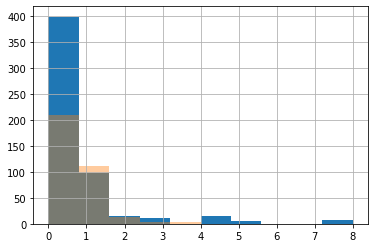

In [257]:
dataset[dataset["Survived"]==0]["SibSp"].hist(bins=10)
dataset[dataset["Survived"]==1]["SibSp"].hist(bins=5, alpha=0.4)


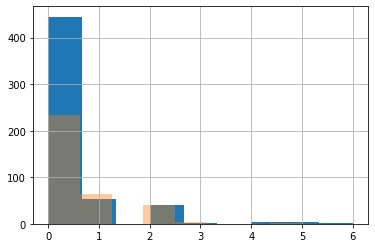

In [258]:
dataset[dataset["Survived"]==0]["Parch"].hist(bins=9)
dataset[dataset["Survived"]==1]["Parch"].hist(bins=8, alpha=0.4)

In [259]:
dataset[(dataset["Survived"]==0) & (dataset["SibSp"]>0) & (dataset["Parch"]>0)]["Survived"].count()

80

In [260]:
dataset[(dataset["Survived"]==1) & (dataset["SibSp"]>0) & (dataset["Parch"]>0)]["Survived"].count()

62

Having a lot of siblings/spouses and children/parents aboard (>4) seems to be bad for your survival chances. It makes sense since you are more likely to refuse board lifeboat when your family is not together or you are not all allowed to board the lifeboat together.

Idea that having more than 0 from both categories, thus traveling with family, might be positive seems to be false since more of those passangers died than survived.

**Embarked**

The port in which a passenger has embarked. C - Cherbourg, S - Southampton, Q = Queenstown. My assumption is this feature has no influence. If the analysis confirms the distribution is close to uniform I shall ommit this feature.

In [261]:
dataset.groupby(['Survived', 'Embarked'])["Embarked"].count()

Survived  Embarked
0         C            75
          Q            47
          S           427
1         C            93
          Q            30
          S           217
Name: Embarked, dtype: int64

In [262]:
print("Survived - S:%.2f%% C:%.2f%% Q:%.2f%%" % (217/(427+217),93/(75+93),30/(30+47)))

Survived - S:0.34% C:0.55% Q:0.39%


In [263]:
dataset.groupby(['Embarked', 'Pclass'])["Pclass"].count()

Embarked  Pclass
C         1          85
          2          17
          3          66
Q         1           2
          2           3
          3          72
S         1         127
          2         164
          3         353
Name: Pclass, dtype: int64

It seems that passangers traveling from Cherbough which was 2nd out of 3 boarding places had higher chance of survival than passangers boarding on the other. This correlates with Pclass since there is high percentage of passangers from 1st class that boarded on this stop. I will keep it in the dataset but might try to ommit it.

**Fare**

Fare feature will most likely be very correlated with Pclass. Lets see if that is true.

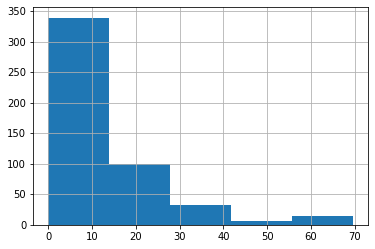

In [264]:
dataset[dataset["Pclass"]==3]["Fare"].hist(bins=5)

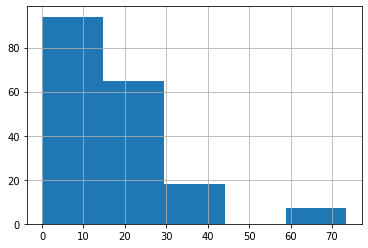

In [265]:
dataset[dataset["Pclass"]==2]["Fare"].hist(bins=5)

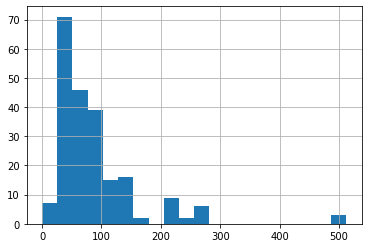

In [266]:
dataset[dataset["Pclass"]==1]["Fare"].hist(bins=20)

Even tough the there are some passangers that payed similar Fare in 3rd and 1st class, there seems to be visible correlation.

**Conclusion**

I think Pclass, Sex and Age are the features that give us the most information. We will try few classifiers with different set of features, however these 3 should always be present.

## Dataset preprocessing ##

Lets select only features we decided to use now and normalize them.

In [267]:
dataset_red = dataset[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch","Fare", "Embarked"]]
mapping_sex = {'male': 0, 'female': 1}
mapping_embarked = {'S': 0, 'C': 1, 'Q': 2}
dataset_red = dataset_red.applymap(lambda s: mapping_sex.get(s) if s in mapping_sex else s)
dataset_red = dataset_red.applymap(lambda s: mapping_embarked.get(s) if s in mapping_embarked else s)
dataset_red_norm = dataset_red.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
dataset_red_norm["Survived"] = dataset_red["Survived"]
dataset_red_norm_no_nan = dataset_red_norm.fillna(value='0')
dataset_red_norm["Age"] = pd.to_numeric(dataset_red_norm["Age"], errors='ignore')
dataset_red_norm["Embarked"] = pd.to_numeric(dataset_red_norm["Age"], errors='ignore')
dataset_red_norm_no_nan["Age"] = pd.to_numeric(dataset_red_norm_no_nan["Age"], errors='ignore')
dataset_red_norm_no_nan["Embarked"] = pd.to_numeric(dataset_red_norm_no_nan["Age"], errors='ignore')

**Split data**

In [268]:
train, test = train_test_split(dataset_red_norm_no_nan, test_size=0.2)
y_train = train["Survived"]
x_train = train.loc[:, train.columns != 'Survived']
y_test = test["Survived"]
x_test = test.loc[:, test.columns != 'Survived']

trainNaN, testNaN = train_test_split(dataset_red_norm, test_size=0.2)
y_trainNaN = train["Survived"]
x_trainNaN = train.loc[:, train.columns != 'Survived']
y_testNaN = test["Survived"]
x_testNaN = test.loc[:, test.columns != 'Survived']

## Training classical classifiers ##

**Logistic regression**

In [269]:
logreg_clf = LogisticRegression(max_iter=100, penalty='l2', solver="lbfgs", tol=1e-10)
logreg_clf.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-10, verbose=0,
                   warm_start=False)

In [270]:
logreg_clf.score(x_train, y_train)

0.7921348314606742

In [271]:
logreg_clf.score(x_test, y_test)

0.8156424581005587

In [272]:
logreg_clf.predict(x_test.iloc[range(20),:]) == y_test.iloc[range(20)].values

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True])

**SVM**

In [273]:
svm_clf = svm.SVC(gamma='auto', kernel='rbf', C=1000)

In [274]:
svm_clf.fit(x_train,y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [275]:
svm_clf.score(x_train, y_train)

0.8258426966292135

In [276]:
svm_clf.score(x_test, y_test)

0.8603351955307262

In [277]:
svm_clf.predict(x_test.iloc[range(20),:]) == y_test.iloc[range(20)].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True])

**AdaBoost**

In [278]:
#best_depth = None
#best_num_clas = None
#best_lr = None
#best_test_score = 0
#
#counter = 0
#for depth in range(2,10):
#    for est_num in np.logspace(1,2.9,20):
#        est_num = int(np.round(est_num))
#        for lr in np.logspace(-3,1,25):
#            ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth), n_estimators=est_num, learning_rate=lr)
#            ada_clf.fit(x_train,y_train)
#            curr_score = ada_clf.score(x_test, y_test)
#            counter += 1
#            if counter%20==0:
#                print("Working... iteration: %i" % (counter))
#            if curr_score > best_test_score:
#                best_test_score = curr_score
#                best_depth = depth
#                best_num_clas = est_num
#                best_lr = lr
#                print("Best Found new best parameters: - depth:%d - num_est:%d - lr:%.4f\n Best test score:%.4f" % (best_depth, best_num_clas, best_lr, curr_score))

best_depth=5
best_num_clas=16
best_lr=0.05
print("Best parameters - depth:%d - num_est:%d - lr:%.2f" % (best_depth, best_num_clas, best_lr))
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=best_depth), n_estimators=best_num_clas, learning_rate=best_lr)
ada_clf.fit(x_train,y_train)                

Best parameters - depth:5 - num_est:16 - lr:0.05


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [279]:
ada_clf.score(x_train, y_train)

0.9241573033707865

In [280]:
ada_clf.score(x_test, y_test)

0.8491620111731844

In [281]:
ada_clf.predict(x_test.iloc[range(20,50),:]) == y_test.iloc[range(20,50)].values

array([ True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

**Submission AdaBoost**

In [282]:
test_data = pd.read_csv("dataset/test.csv")
test_data_red = test_data[["Pclass", "Sex", "Age", "SibSp", "Parch","Fare", "Embarked"]]
mapping_sex = {'male': 0, 'female': 1}
mapping_embarked = {'S': 0, 'C': 1, 'Q': 2}
test_data_red = test_data_red.applymap(lambda s: mapping_sex.get(s) if s in mapping_sex else s)
test_data_red = test_data_red.applymap(lambda s: mapping_embarked.get(s) if s in mapping_embarked else s)
test_data_red_norm = test_data_red.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
test_data_red_norm = test_data_red_norm.fillna(value='0')

selected_clf = ada_clf
predictions = ada_clf.predict(test_data_red_norm)
test_predictions = test_data[["PassengerId"]]
test_predictions.insert(loc=1, column='Survived', value=predictions)
test_predictions.to_csv("kaggle_submission_adaboost", index=False)

**XGBoost**

In [283]:
x_trainNaN.dtypes

Pclass      float64
Sex         float64
Age         float64
SibSp       float64
Parch       float64
Fare        float64
Embarked    float64
dtype: object

In [284]:
#best_depth = None
#best_num_clas = None
#best_lr = None
#best_test_score = 0
#
#counter = 0
#for depth in range(2,20,2):
#    for est_num in np.logspace(1,2.9,20):
#        est_num = int(np.round(est_num))
#        for lr in np.logspace(-3,1,25):
#            xgboost_clf = XGBClassifier(max_depth=depth, learning_rate=lr, n_estimators=est_num, missing=np.nan)
#            xgboost_clf.fit(x_trainNaN,y_trainNaN)
#            curr_score = xgboost_clf.score(x_testNaN, y_testNaN)
#            counter += 1
#            if counter%20==0:
#                print("Working... iteration: %i" % (counter))
#            if curr_score > best_test_score:
#                best_test_score = curr_score
#                best_depth = depth
#                best_num_clas = est_num
#                best_lr = lr
#                print("Best Found new best parameters: - depth:%d - num_est:%d - lr:%.4f\n Best test score:%.4f" % (best_depth, best_num_clas, best_lr, curr_score))
xgboost_clf = XGBClassifier(max_depth=4, learning_rate=0.3162, n_estimators=32, missing=np.nan)
xgboost_clf.fit(x_trainNaN,y_trainNaN)
print("Train score: {}, Test score: {}".format(xgboost_clf.score(x_trainNaN, y_trainNaN),xgboost_clf.score(x_testNaN, y_testNaN)))
xgboost_clf.predict(x_test.iloc[range(20,50),:]) == y_test.iloc[range(20,50)].values

Train score: 0.8820224719101124, Test score: 0.8491620111731844


array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True])

**Submission XGBoost**

In [285]:
test_data = pd.read_csv("dataset/test.csv")
test_data_red = test_data[["Pclass", "Sex", "Age", "SibSp", "Parch","Fare", "Embarked"]]
mapping_sex = {'male': 0, 'female': 1}
mapping_embarked = {'S': 0, 'C': 1, 'Q': 2}
test_data_red = test_data_red.applymap(lambda s: mapping_sex.get(s) if s in mapping_sex else s)
test_data_red = test_data_red.applymap(lambda s: mapping_embarked.get(s) if s in mapping_embarked else s)
test_data_red_norm = test_data_red.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

selected_clf = xgboost_clf
predictions = xgboost_clf.predict(test_data_red_norm)
test_predictions = test_data[["PassengerId"]]
test_predictions.insert(loc=1, column='Survived', value=predictions)
test_predictions.to_csv("kaggle_submission_xgboost", index=False)

## Training simple NNs ##

In [84]:
def TitanicModel(input_shape):
    X_input = Input(input_shape)
    X = Flatten()(X_input)
    X = Dense(2, activation='sigmoid', name='dense1')(X)
    #X = Dense(13, activation='relu', name='dense2')(X)
    X = Dense(1, activation='sigmoid', name='dense3')(X)
    model = Model(inputs = X_input, outputs = X, name='TitanicModel')
    return model

In [85]:
titanicModel = TitanicModel((1,7))
adamOpt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10**(-8))
titanicModel.compile(optimizer = adamOpt, loss = "mean_squared_error", metrics = ["accuracy"])
titanicModel.summary()

Model: "TitanicModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 7)]            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense1 (Dense)               (None, 2)                 16        
_________________________________________________________________
dense3 (Dense)               (None, 1)                 3         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


In [86]:
x_train_keras = x_train.values.reshape(712,1,7)
y_train_keras = y_train.values.reshape(712,1)

In [87]:
titanicModel.fit(x = x_train_keras, y = y_train_keras, epochs = 50, batch_size = 16)

Epoch 1/50
712/712 [==============================] - 0s 191us/sample - loss: 0.3247 - accuracy: 0.3904
Epoch 2/50
712/712 [==============================] - 0s 66us/sample - loss: 0.3121 - accuracy: 0.3904
Epoch 3/50
712/712 [==============================] - 0s 58us/sample - loss: 0.3007 - accuracy: 0.3904
Epoch 4/50
712/712 [==============================] - 0s 56us/sample - loss: 0.2904 - accuracy: 0.3904
Epoch 5/50
712/712 [==============================] - 0s 53us/sample - loss: 0.2816 - accuracy: 0.3904
Epoch 6/50
712/712 [==============================] - 0s 53us/sample - loss: 0.2741 - accuracy: 0.3904
Epoch 7/50
712/712 [==============================] - 0s 56us/sample - loss: 0.2674 - accuracy: 0.3904
Epoch 8/50
712/712 [==============================] - 0s 54us/sample - loss: 0.2617 - accuracy: 0.3904
Epoch 9/50
712/712 [==============================] - 0s 60us/sample - loss: 0.2569 - accuracy: 0.3904
Epoch 10/50
712/712 [==============================] - 0s 52us/sample - 